In [115]:
# pip install sysidentpy=="0.1.6"
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.utils.display_results import results
from sklearn.metrics import r2_score
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

1. Importar dados do braço robótico

In [116]:
data = pd.read_csv('./robot_arm.dat',sep='\t',names=['u','y'],index_col=False)
print(data.shape)
y = data.y.values.reshape(-1, 1)
u = data.u.values.reshape(-1, 1)

(1024, 2)


2. Estudar a influência das ordens no desempenho do modelo ARMAX

In [188]:
r = []
basis_function = Polynomial(degree=1)
for ylag in range(1,10):
    for xlag in range(1,10):
        for elag in range(1,10):
            model = FROLS(basis_function=basis_function,
                            order_selection=True,
                            n_info_values=10,
                            extended_least_squares=False,
                            ylag=ylag, xlag=xlag, elag=elag,
                            info_criteria='aic',
                            estimator='least_squares',
                            model_type='NARMAX',
                            )
            model.fit(X=u, y=y)
            yhat = model.predict(X=u, y=y, steps_ahead=None)
            r2 = r2_score(y, yhat)
            r.append([ylag, xlag, elag, r2])

3. Critério: R^2 >= 0.9

In [194]:
r = pd.DataFrame(r,columns=['ylag','xlag','elag','r2'])
r.sort_values(by='r2', ascending=False)

,ylag,xlag,elag,r2
236,3,9,3,9.123006e-01
237,3,9,4,9.123006e-01
238,3,9,5,9.123006e-01
239,3,9,6,9.123006e-01
240,3,9,7,9.123006e-01
...,...,...,...,...
473,6,8,6,-1.676870e+141
474,6,8,7,-1.676870e+141
475,6,8,8,-1.676870e+141
476,6,8,9,-1.676870e+141


In [195]:
r = r[r.r2 >= 0.9]

In [198]:
r['total number of lags'] = r[r.r2 >= 0.9][['ylag','xlag','elag']].sum(axis=1)
opt = r.sort_values(by='total number of lags',ascending=True).iloc[0]
opt

ylag                     3.000000
xlag                     7.000000
elag                     1.000000
r2                       0.900322
total number of lags    11.000000
Name: 216, dtype: float64

R^2: 0.9003219177952834


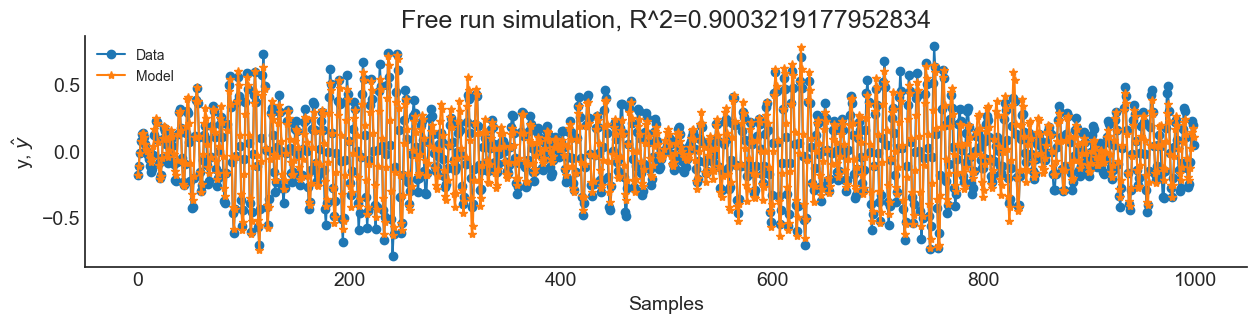

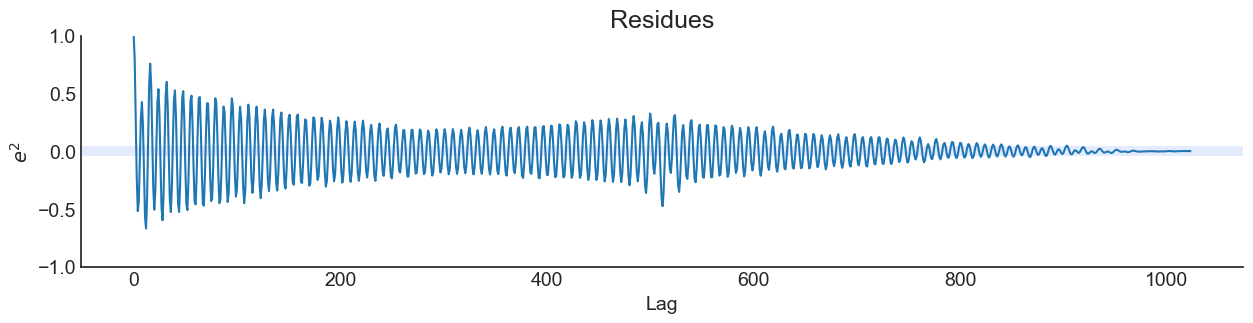

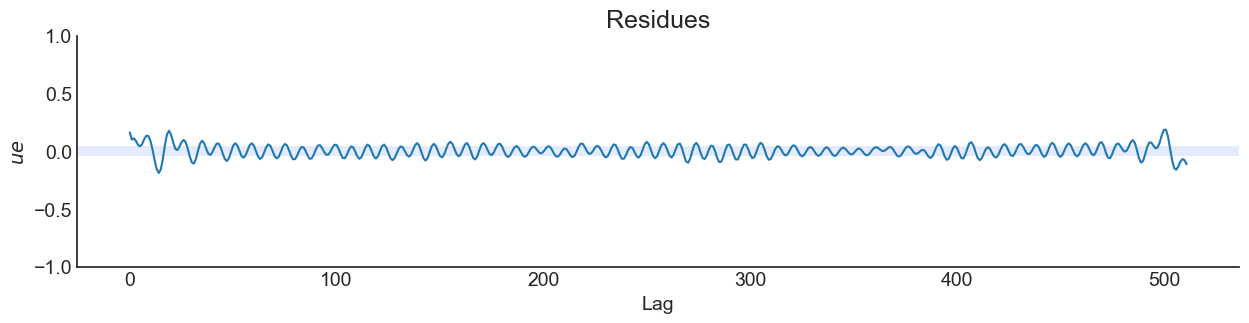

In [199]:
basis_function = Polynomial(degree=1)
model = FROLS(basis_function=basis_function,
                order_selection=True,
                n_info_values=10,
                extended_least_squares=False,
                ylag=int(opt.ylag), xlag=int(opt.xlag), elag=int(opt.elag),
                info_criteria='aic',
                estimator='least_squares',
                model_type='NARMAX',
                )

model.fit(X=u, y=y)
yhat = model.predict(X=u, y=y, steps_ahead=None)
r2 = r2_score(y, yhat)
print(f'R^2: {r2}')

figsize = (15,3)
plot_results(y=y, yhat = yhat, n=1000,figsize=figsize,title=f'Free run simulation, R^2={r2}')

ee = compute_residues_autocorrelation(y, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$",figsize=figsize)

x1e = compute_cross_correlation(y, yhat, u)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$ue$",figsize=figsize)

In [200]:
r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)

  Regressors   Parameters             ERR
0     y(k-1)   2.3563E+00  5.16393638E-01
1     y(k-2)  -2.3308E+00  4.71424920E-01
2     y(k-3)   9.5240E-01  8.73334176E-03
3    x1(k-4)   4.9071E+00  1.13820310E-03
4    x1(k-1)  -7.9815E-01  9.15968253E-05
5    x1(k-2)   2.6088E+00  2.19457774E-04
6    x1(k-3)  -4.4638E+00  7.44482134E-04
7    x1(k-5)  -3.4800E+00  3.16901061E-04
8    x1(k-6)   1.5862E+00  1.38669143E-05
9    x1(k-7)  -3.8033E-01  9.66114495E-05
